# Session 12: Sentiment analysis

Notebook by Terence Broad and Rebecca Fiebrink
In this notebook we will look at how to perform sentiment analysis with the NLTK library. We will perform this on the [weratedogs dataset](https://git.arts.ac.uk/tbroad/we-rate-dogs-dataset) that was [built using web scraping](https://git.arts.ac.uk/tbroad/web-scrape-we-rate-dogs) from instagram. If you have not seen the [weratedogs instagram account](https://www.instagram.com/weratedogs/?hl=en) use this as an excuse to look at some cute dog pictures for five minutes.

First lets do some imports:

In [1]:
# Basic libraries
import re
import nltk
import numpy as np
import pandas as pd

# NLTK utils
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# SK-Learn classification report for evaluating sentiment analysis
from sklearn.metrics import classification_report

And downloads:

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/toniayon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/toniayon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/toniayon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/toniayon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Define our POS tagger for lemmatisation:

In [3]:
# Function originally from: https://www.programcreek.com/python/?CodeExample=get%20wordnet%20pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Now lets load our dataset in.
(Note that this dataset comes from Terence's repository at https://git.arts.ac.uk/tbroad/we-rate-dogs-dataset, where you can also see the dog images corresponding to this data.)

In [5]:
df = pd.read_csv('../../data/weratedogs_ratings.tsv', sep='\t')
df = df.drop('doggo_index', axis=1)
df

,doggo_rating,comment
0,12,This is Coco. At first I thought she was a clo...
1,14,This is Carlton. He's being hailed a hero for ...
2,13,"This is Carolina, Dawson, Claudia, and Cecilia..."
3,14,This is Cookie. Some people wear their heart o...
4,13,We don’t rate snowflakes. We only rate dogs. T...
...,...,...
3038,13,This is Tilly. She's just checking pup on you....
3039,7,This is Biden. Biden just tripped... 7/10
3040,14,This is Seamus. He was diagnosed with terminal...
3041,12,This is Brewski. He’s not the step dad. He’s t...


Lets do some pre-processing, by removing stop words and performing lemmatisation. Here we are also manually removing the ratings of each dog using regex.

In [14]:
lemmatizer = WordNetLemmatizer()
for index, row in df.iterrows():
    comment = row['comment']
    # Remove the numerical score rating from the comment
    comment_no_rating = re.sub(' ([0-9]*)\/10', '', comment)
    commen_no_stop_words = [word for word in comment_no_rating.split() if word not in stopwords.words('english')]
    lemmitized_comment = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in commen_no_stop_words])
    df.loc[index, 'comment'] = lemmitized_comment
df

,doggo_rating,comment
0,12,This Coco. At first I thought cloud cloud bork...
1,14,This Carlton. He's hail hero save life dog nee...
2,13,"This Carolina, Dawson, Claudia, Cecilia. They ..."
3,14,This Cookie. Some people wear heart sleeve. Sh...
4,13,We don’t rate snowflakes. We rate dogs. This s...
...,...,...
3038,13,This Tilly. She's check pup you. Hopes ok. If ...
3039,7,This Biden. Biden tripped...
3040,14,This Seamus. He diagnose terminal brain cancer...
3041,12,This Brewski. He’s step dad. He’s dad step up....


Lets create our sentiment analyser class and test it on one comment. We will get a dictionary returned to use with four components: `neg` (negative sentiment), `neu` (neutral sentiment), `pos` (positive sentiment) and `compound` (a weighted average of the three scores).  

In [15]:
analyzer = SentimentIntensityAnalyzer()

individual_sentiment = analyzer.polarity_scores(df['comment'][0])
individual_sentiment

{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'compound': 0.7269}

#### Sentiment analysis function

This function will give us a binary score for positive or negative sentiment based on the compound score:

In [16]:
# This block of code is derived from: https://www.datacamp.com/tutorial/text-analytics-beginners-nltk
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['compound'] > 0 else 0
    return sentiment

In [17]:
#You can try it out yourself:
get_sentiment("WOW WHAT A CUTE DOG")

1

Now lets add our sentiment score to our data:

In [18]:
df['sentiment'] = df['comment'].apply(get_sentiment)
df


,doggo_rating,comment,sentiment
0,12,This Coco. At first I thought cloud cloud bork...,1
1,14,This Carlton. He's hail hero save life dog nee...,1
2,13,"This Carolina, Dawson, Claudia, Cecilia. They ...",1
3,14,This Cookie. Some people wear heart sleeve. Sh...,0
4,13,We don’t rate snowflakes. We rate dogs. This s...,1
...,...,...,...
3038,13,This Tilly. She's check pup you. Hopes ok. If ...,1
3039,7,This Biden. Biden tripped...,0
3040,14,This Seamus. He diagnose terminal brain cancer...,0
3041,12,This Brewski. He’s step dad. He’s dad step up....,0


Lets see if there is any correlation with our data?

In [19]:
correlation = df['doggo_rating'].corr(df['sentiment'])
print(correlation)

0.04960499661064983


The correlation is very low. Anything about 0.4 is deemed as [weak positive correlation](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/strength-of-correlation.html).

Lets try diving our data into positive and negative ratings. First lets look at our distribution of ratings:

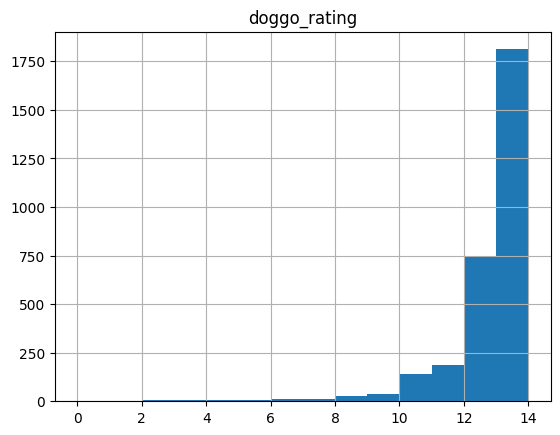

In [20]:
hist = df.hist(column = 'doggo_rating', bins=[0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12, 13, 14])

#### Divide dataset based on ratings

Lets make a binary variable that is `1` for any rating above 10 and `0` for any rating 10 or below:

In [21]:
df['above_ten'] = np.where(df['doggo_rating'] > 11, 1, 0)
df

,doggo_rating,comment,sentiment,above_ten
0,12,This Coco. At first I thought cloud cloud bork...,1,1
1,14,This Carlton. He's hail hero save life dog nee...,1,1
2,13,"This Carolina, Dawson, Claudia, Cecilia. They ...",1,1
3,14,This Cookie. Some people wear heart sleeve. Sh...,0,1
4,13,We don’t rate snowflakes. We rate dogs. This s...,1,1
...,...,...,...,...
3038,13,This Tilly. She's check pup you. Hopes ok. If ...,1,1
3039,7,This Biden. Biden tripped...,0,0
3040,14,This Seamus. He diagnose terminal brain cancer...,0,1
3041,12,This Brewski. He’s step dad. He’s dad step up....,0,1


Lets look at the distribution of these variables:

In [22]:
print(df['above_ten'].value_counts())

above_ten
1    2603
0     440
Name: count, dtype: int64


Now lets compare our correlation again with our new variable and our sentiment:

In [25]:
correlation = df['above_ten'].corr(df['sentiment'])
print(correlation)

0.19216913054787244


It is slightly higher but still would be deemed as very weak positive correlation. 

Now lets see if we used our sentiment score for classification how it would perform:

In [24]:
print(classification_report(df['above_ten'], df['sentiment']))

              precision    recall  f1-score   support

           0       0.25      0.49      0.33       440
           1       0.90      0.76      0.82      2603

    accuracy                           0.72      3043
   macro avg       0.58      0.62      0.58      3043
weighted avg       0.80      0.72      0.75      3043


The results are not terrible, if we were to treat our sentiment analyser as a naive classifier. 

## Tasks

**Task 1** Can you change the feature used for determining positive or negative sentiment in [the cell that defines the sentiment analysis function](#sentiment-analysis-function) does that improve the correlation and/or the classification report?

**Task 2** If you were to [divide up the dataset based on ratings](#divide-dataset-based-on-ratings) differently, do you get better or worse results from correlation and/or the classification report?

**Task 3** If you were to put the real valued sentiment scores into the dataframe (in [the cell that defines the sentiment analysis function](#sentiment-analysis-function)) instead of binary values, does that improve the correlation coefficient?

### Bonus tasks

**Task A** Can you train a classifier on this dataset? How does that compare to the using sentiment analysis as a classifier?

**Task B** Can you find another dataset on [kaggle](https://www.kaggle.com/) to perform sentiment anlysis on? Make a copy of this notebook and adapt it to the new dataset.